In [30]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from datetime import datetime
from scipy.signal import find_peaks
from scipy.stats import gamma
import statsmodels.api as sm
import warnings

In [31]:
data = pd.read_csv("train_ML_IOT.csv")

In [32]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

data['Year'] = [date.year for date in data.DateTime]
data['Quarter'] = [date.quarter for date in data.DateTime]
data['Weekday'] = [datetime.weekday(date) for date in data.DateTime]
data["IsWeekend"] = data["Weekday"] >= 5
data['Month'] = [date.month for date in data.DateTime]
data['Week'] = [date.week for date in data.DateTime]
data['Day'] = [date.day for date in data.DateTime]
data['Hour'] = [date.hour for date in data.DateTime]

In [33]:
junction_1 = data[data["Junction"]==1]
junction_2 = data[data["Junction"]==2]
junction_3 = data[data["Junction"]==3]
junction_4 = data[data["Junction"]==4]

junctions = [junction_1, junction_2, junction_3, junction_4]

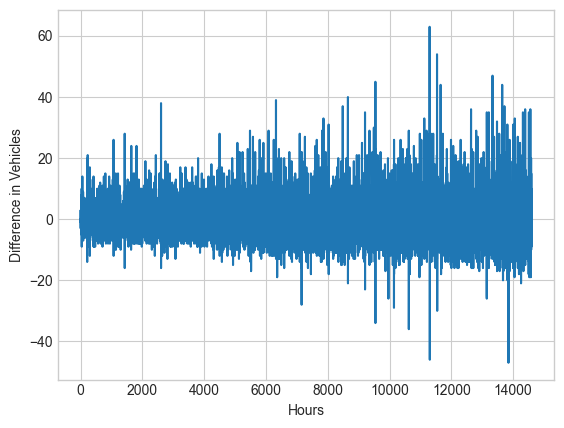

In [34]:
vehicle_diff = np.diff(junction_1.Vehicles)
vehicle_diff = np.insert(vehicle_diff, 0, 0)

plt.plot(np.arange(len(junction_1.Vehicles)), vehicle_diff)
plt.xlabel("Hours")
plt.ylabel("Difference in Vehicles")
plt.show()

To plot the differences between consecutive data points

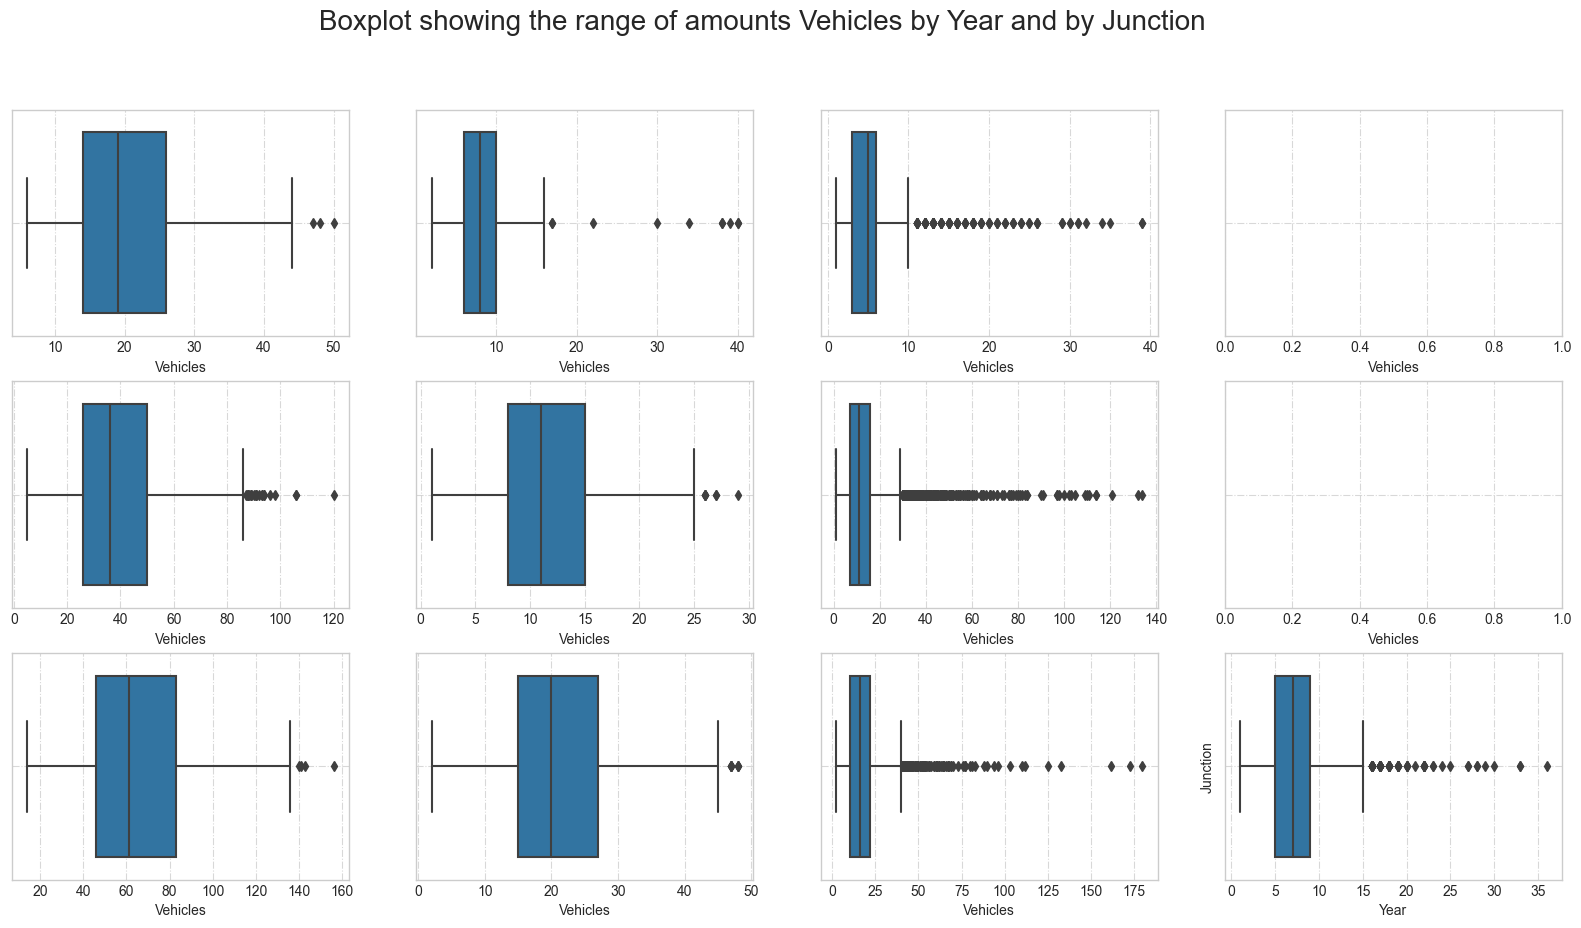

In [35]:
f, axis = plt.subplots(3, 4, figsize=(20, 10))

for i, year in zip(range(3), range(2015, 2018)):
  for j, junction in zip(range(4), range(1, 5)):
    sns.boxplot(x=data[(data.Junction == junction) & (data.Year == year)]['Vehicles'], ax=axis[i, j])
    axis[i, j].grid(True, alpha=0.75, ls='-.')

plt.xlabel('Year')
plt.ylabel('Junction')
f.suptitle('Boxplot showing the range of amounts Vehicles by Year and by Junction', fontsize=20)
plt.show()

In boxplot, we can see a lot of outliers (those which is the dot)

### One Hot Encoding

One-Hot Encoding is a data conversion technique used to convert categorical data (category or class labels) into numerical data.

Defines a function that converts date and time values in a data frame to a Unix timestamp.

In [36]:
def date_to_unix(df):
    unix_time = []  # Initialising unixtime list
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unix_time.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unix_time
    return(df)

In [37]:
data_features = date_to_unix(data.drop(['Vehicles', 'Year', 'Quarter', 'Month'], axis=1))
X = data_features

In [38]:
X.Junction = X.Junction.astype("str")
X.Weekday = X.Weekday.astype("str")
X.Day = X.Day.astype("str")

In [39]:
X = pd.get_dummies(X)
y = data.Vehicles.to_frame()
X

,DateTime,ID,IsWeekend,Week,Hour,Junction_1,Junction_2,Junction_3,Junction_4,Weekday_0,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,1.446325e+09,20151101001,True,44,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.446329e+09,20151101011,True,44,1,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.446332e+09,20151101021,True,44,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.446336e+09,20151101031,True,44,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.446340e+09,20151101041,True,44,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,1.498838e+09,20170630194,False,26,19,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
48116,1.498842e+09,20170630204,False,26,20,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
48117,1.498846e+09,20170630214,False,26,21,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
48118,1.498849e+09,20170630224,False,26,22,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [40]:
y

,Vehicles
0,15
1,13
2,10
3,7
4,9
...,...
48115,11
48116,30
48117,16
48118,22


## Outlier Detection

In [41]:
!pip install adtk
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import SeasonalAD
from adtk.detector import InterQuartileRangeAD
from adtk.detector import GeneralizedESDTestAD
from adtk.detector import PersistAD
from adtk.detector import VolatilityShiftAD

In [42]:
jads = [junction_1, junction_2, junction_3, junction_4]
for i,j in enumerate(junctions):
    jads[i] = j.Vehicles
    jads[i].index = j.DateTime

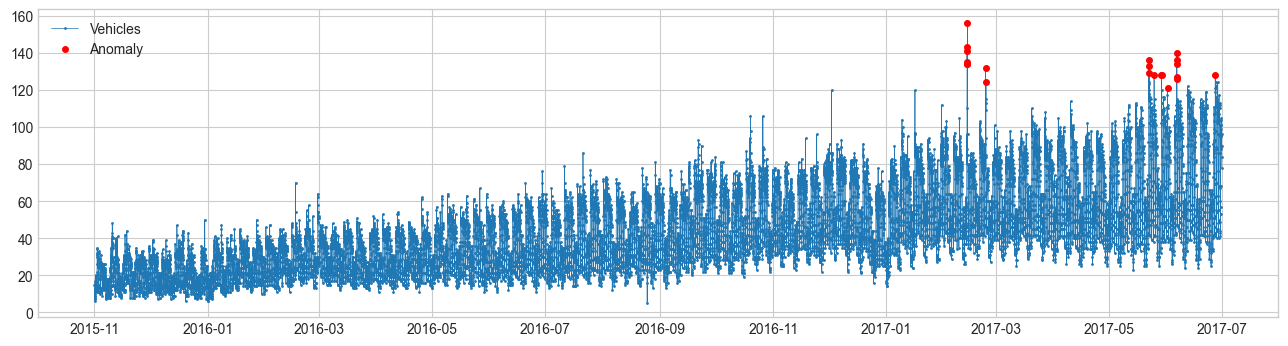

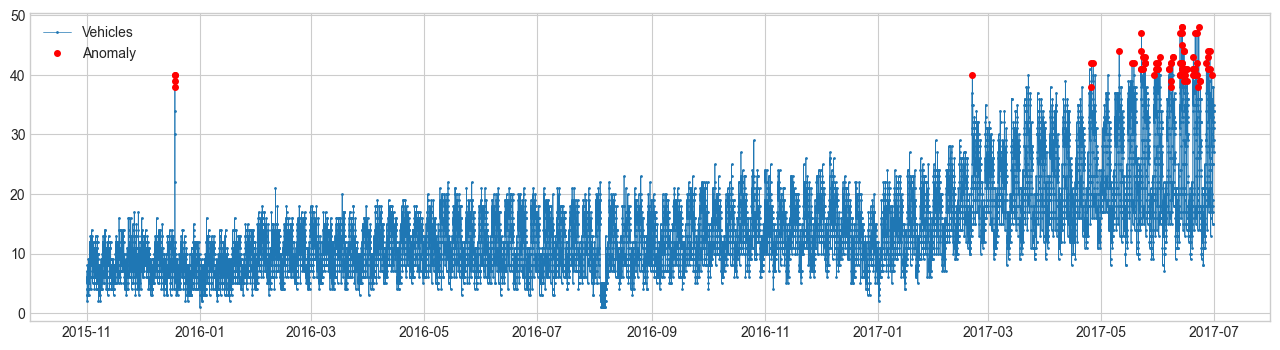

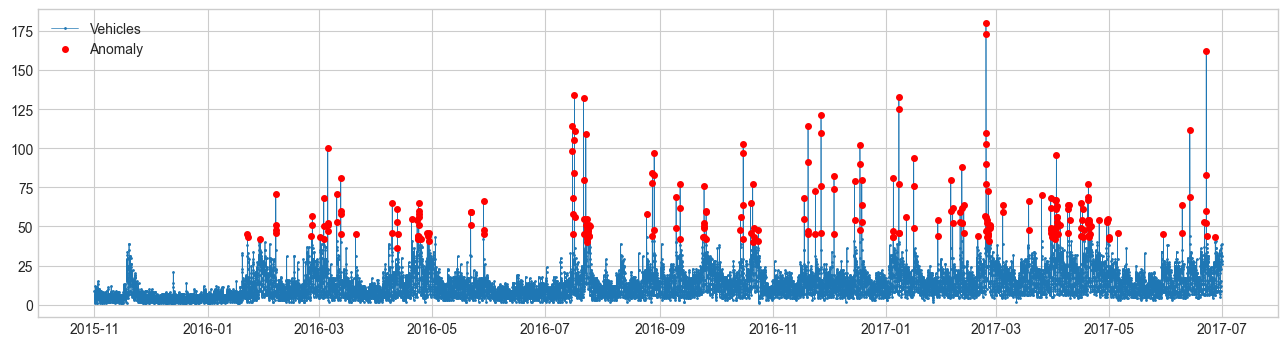

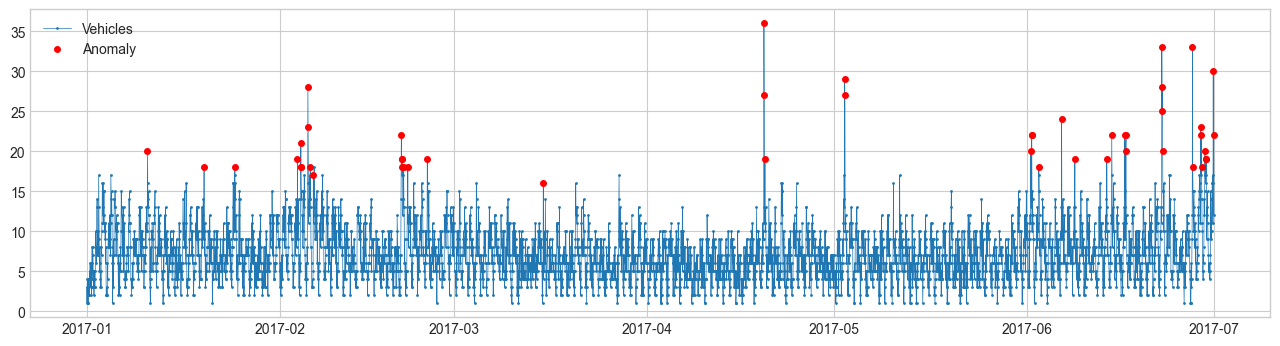

In [67]:
seasonal_vol = SeasonalAD()
for jad in jads:
    jad = validate_series(jad)
    anomalies = seasonal_vol.fit_detect(jad)
    anomalies.value_counts()
    plot(jad, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
    plt.show()

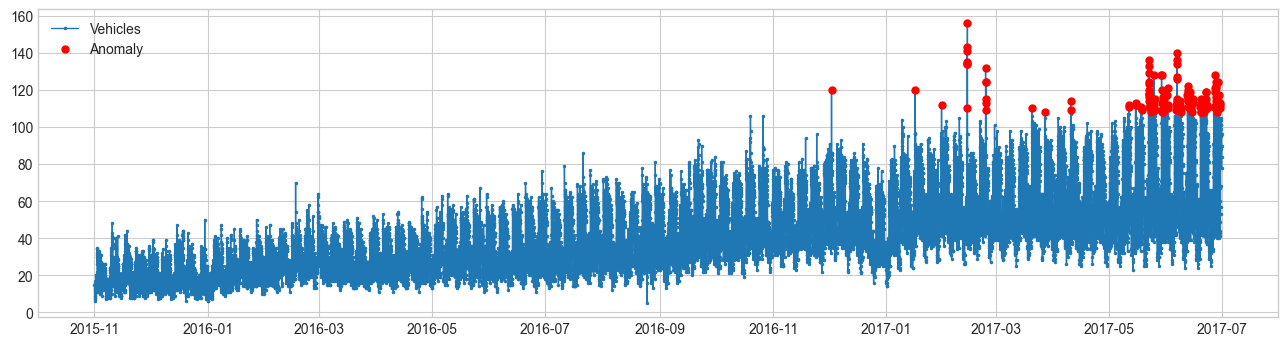

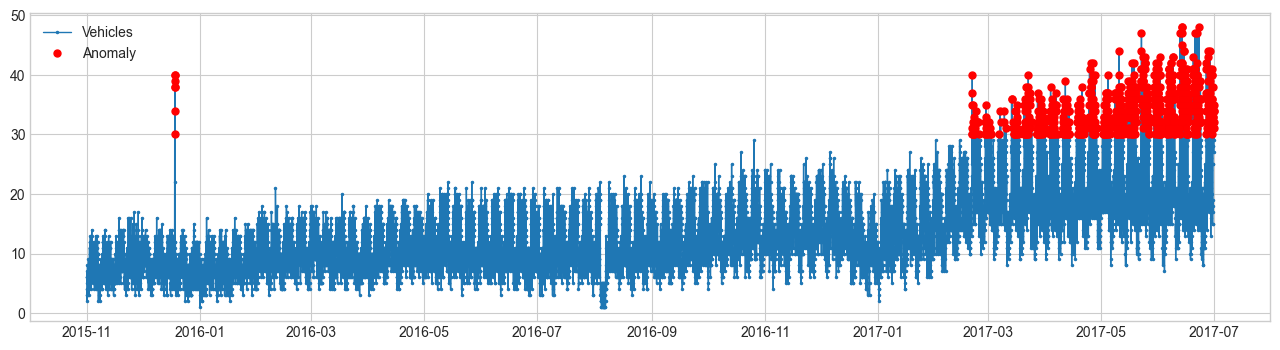

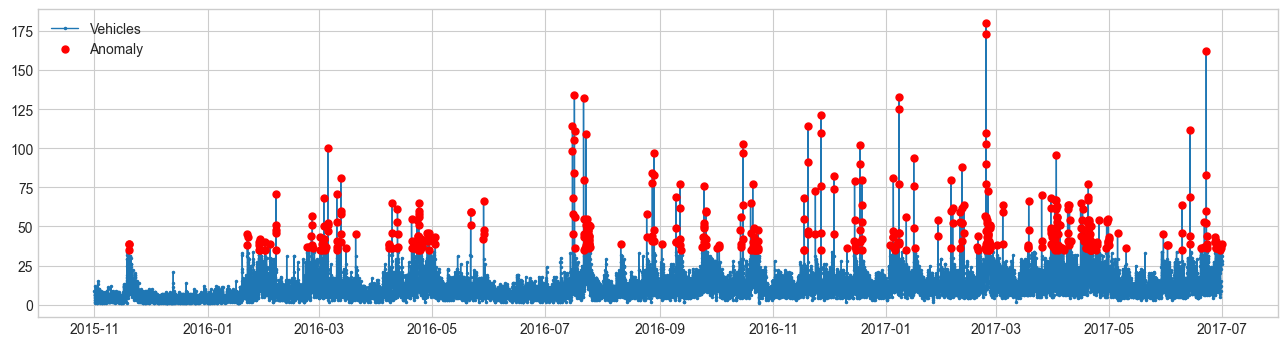

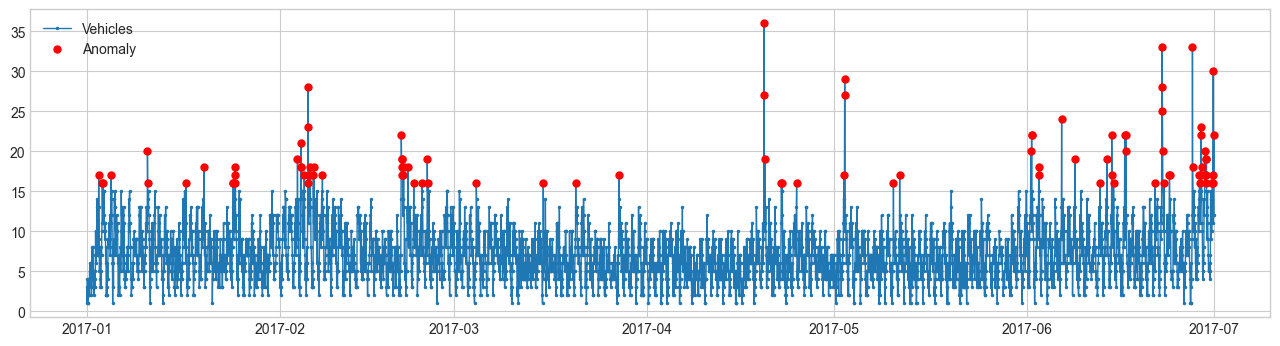

In [69]:
iqr_ad = InterQuartileRangeAD(c=1.5)
for jad in jads:
    anomalies = iqr_ad.fit_detect(jad)
    plot(jad, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

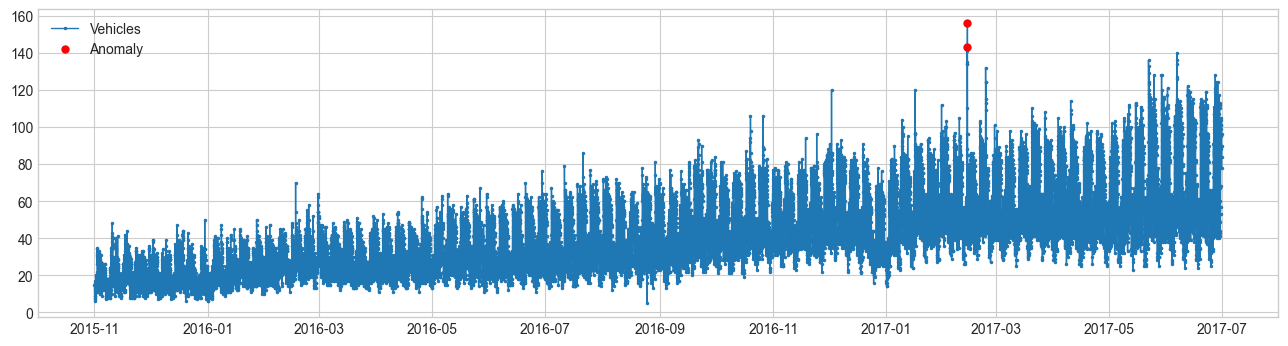

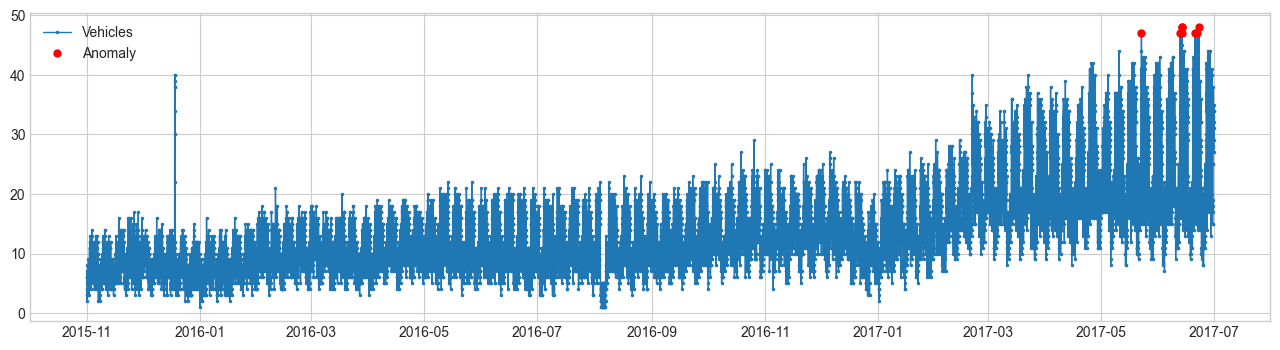

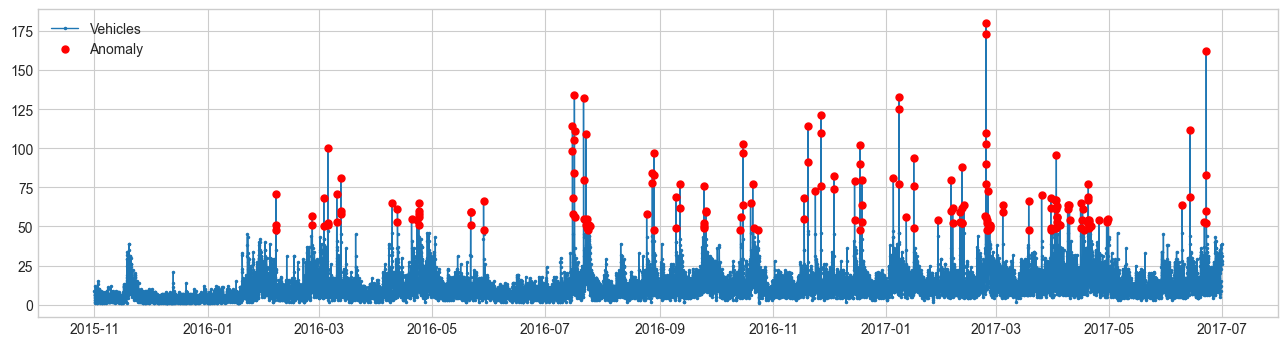

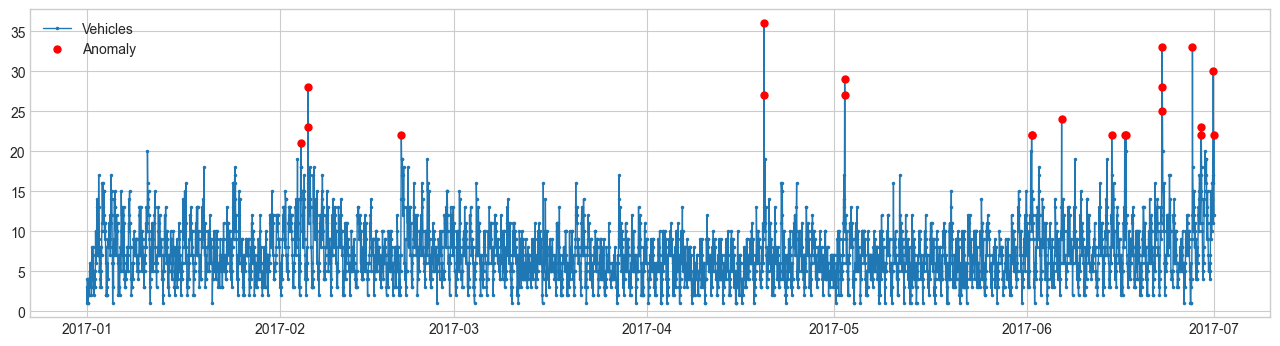

In [70]:
esd_ad = GeneralizedESDTestAD(alpha=0.3)
for jad in jads:
    anomalies = esd_ad.fit_detect(jad)
    plot(jad, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

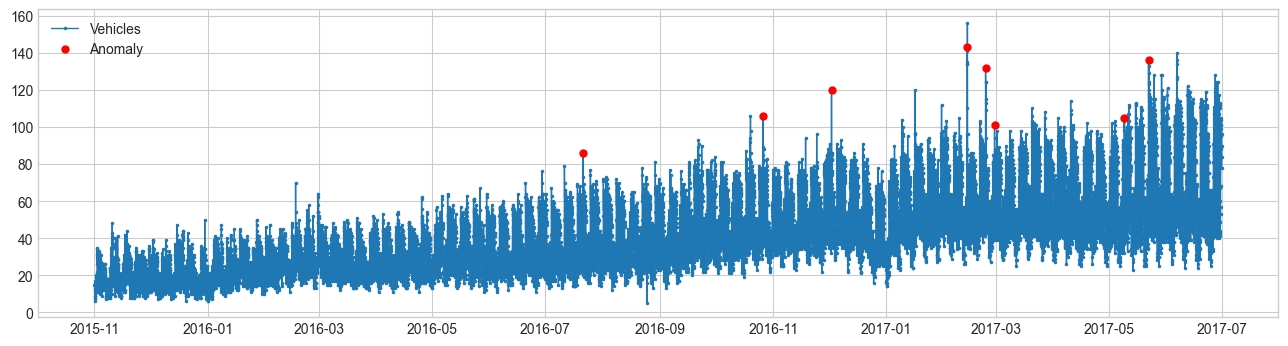

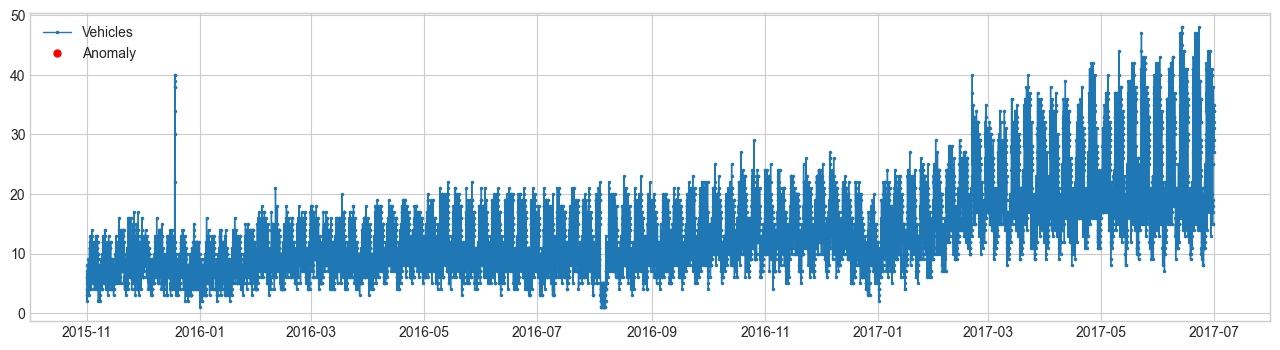

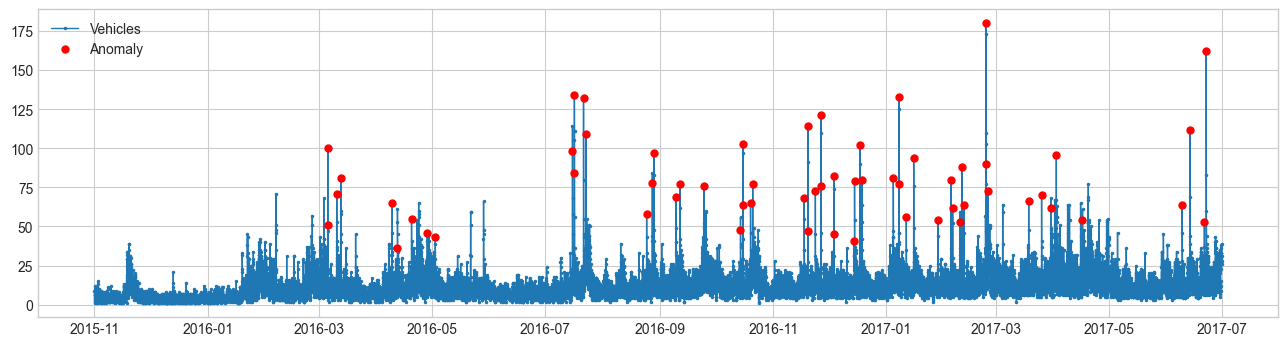

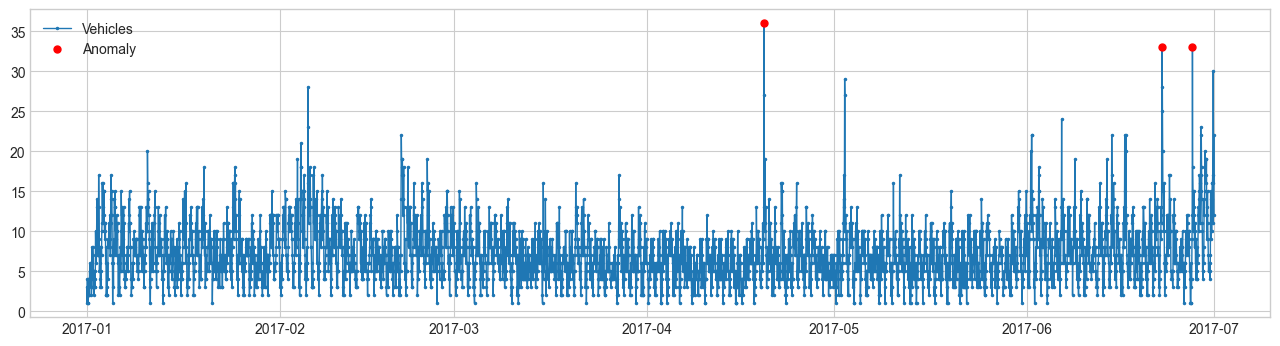

In [71]:
persist_ad = PersistAD(c=8, side='positive')
for jad in jads:
    anomalies = persist_ad.fit_detect(jad)
    plot(jad, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

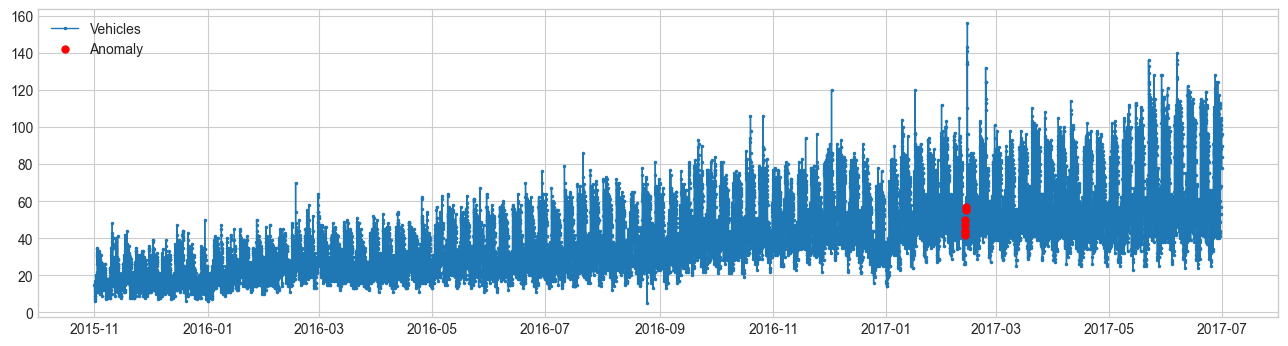

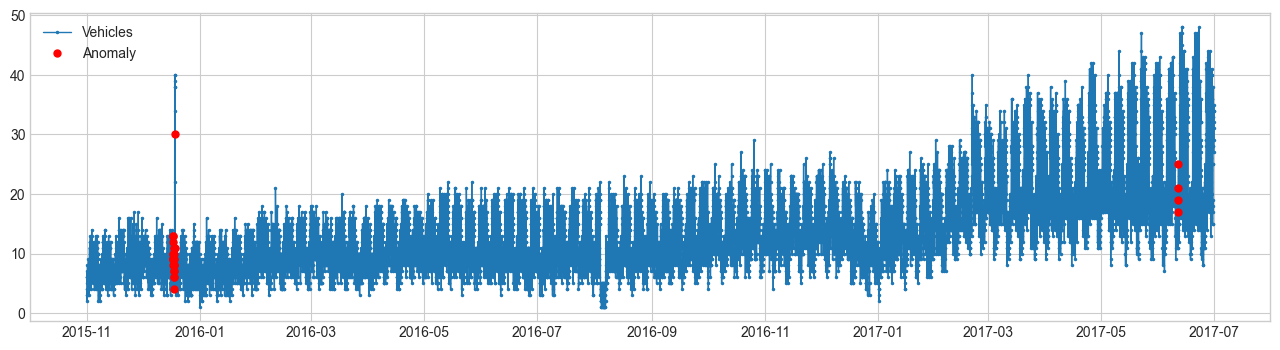

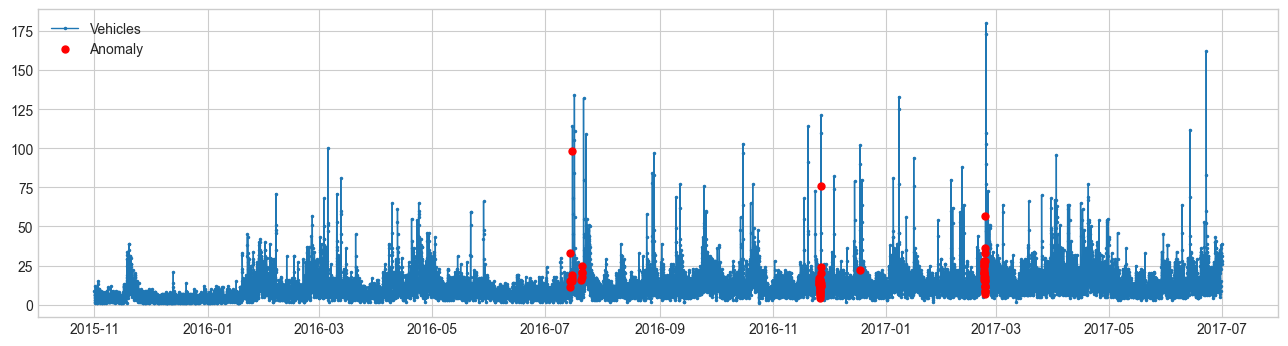

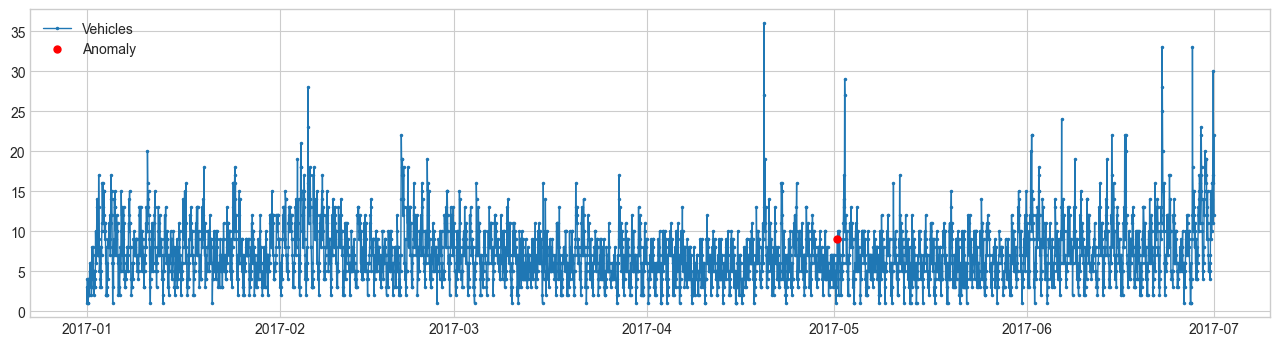

In [73]:
volatility_shift_ad = VolatilityShiftAD(c=8, side='positive', window=30)
for jad in jads:
    anomalies = volatility_shift_ad.fit_detect(jad)
    plot(jad, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(dataframe, junction_name):
    
    decomposition = seasonal_decompose(dataframe['Vehicles'], model='additive', period=24)  # Assuming a daily seasonality
    
    # Create subplots for trend, seasonal, and residual components
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    
    # Original time series
    axes[0].set_title(f'{junction_name} - Original Time Series')
    axes[0].plot(dataframe.index, dataframe['Vehicles'], label='Original', color='blue')
    
    # Trend component
    axes[1].set_title('Trend Component')
    axes[1].plot(decomposition.trend.index, decomposition.trend, label='Trend', color='green')
    
    # Seasonal component
    axes[2].set_title('Seasonal Component')
    axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonal', color='red')
    
    # Residual component
    axes[3].set_title('Residual Component')
    axes[3].plot(decomposition.resid.index, decomposition.resid, label='Residual', color='purple')
    
    plt.tight_layout()
    
    for ax in axes:
        ax.legend()
    
    plt.show()

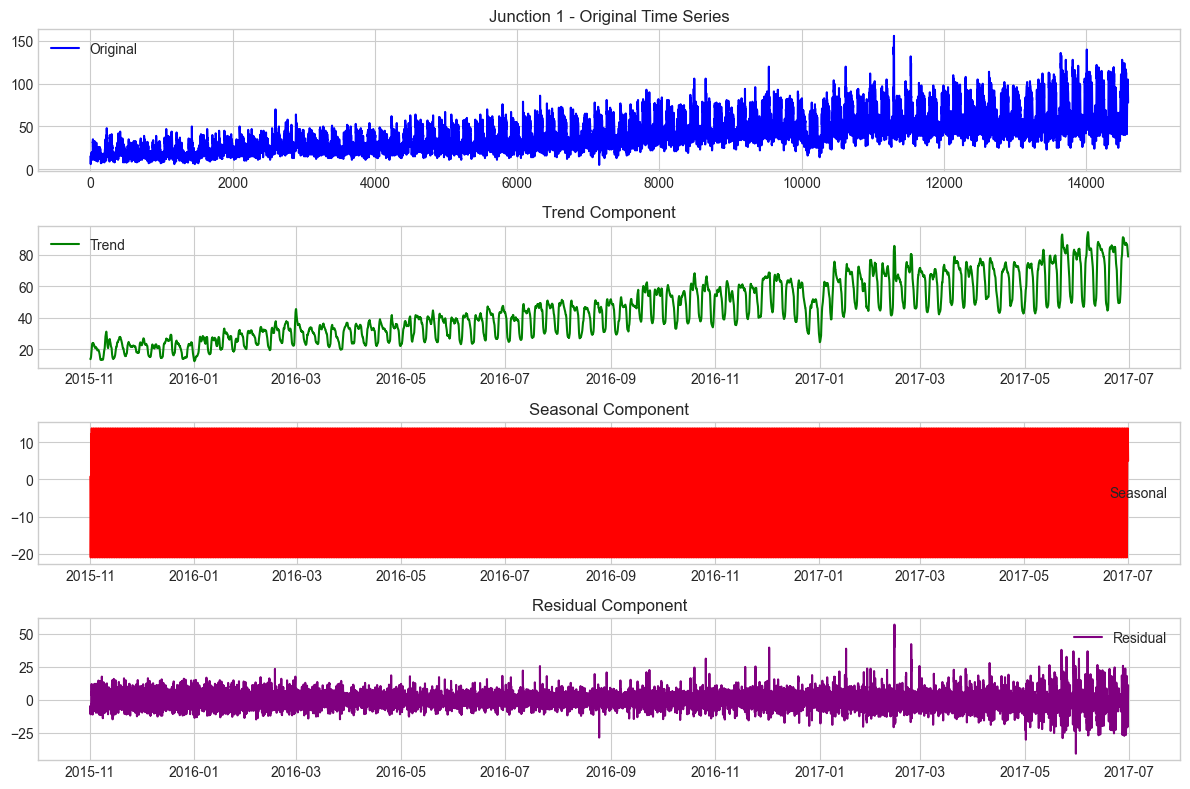

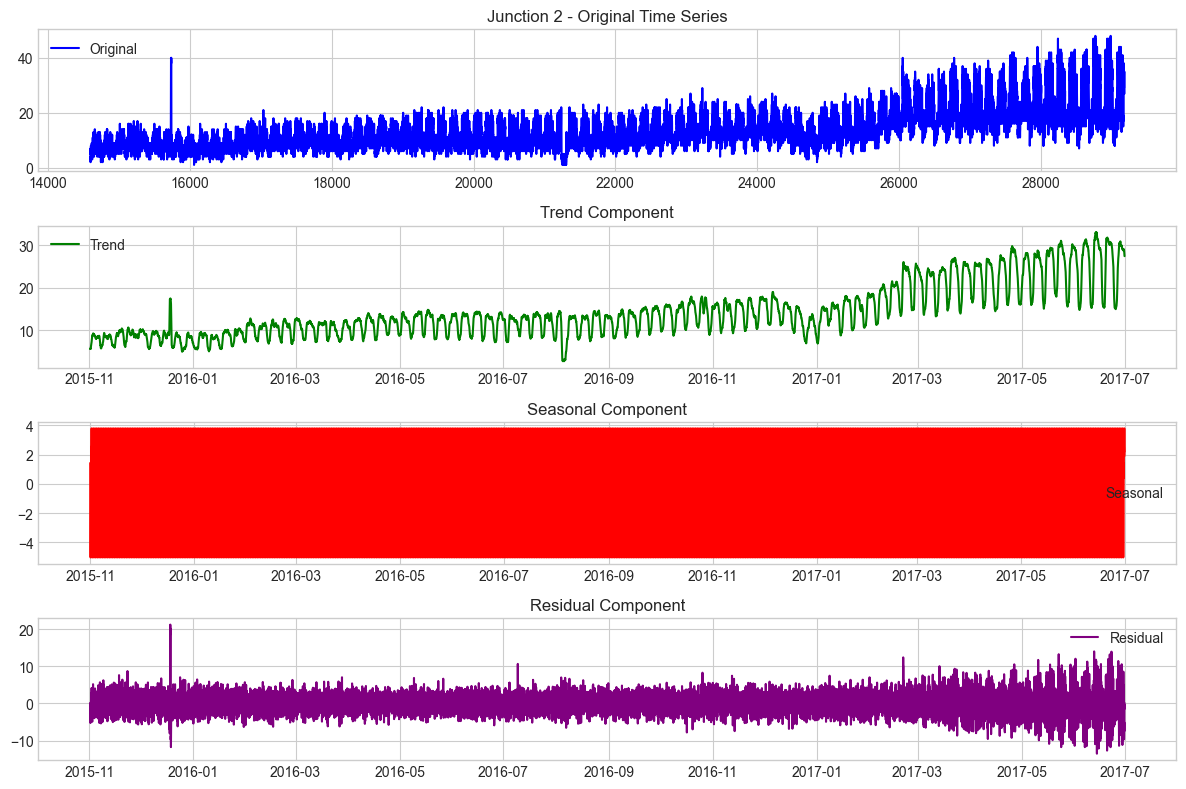

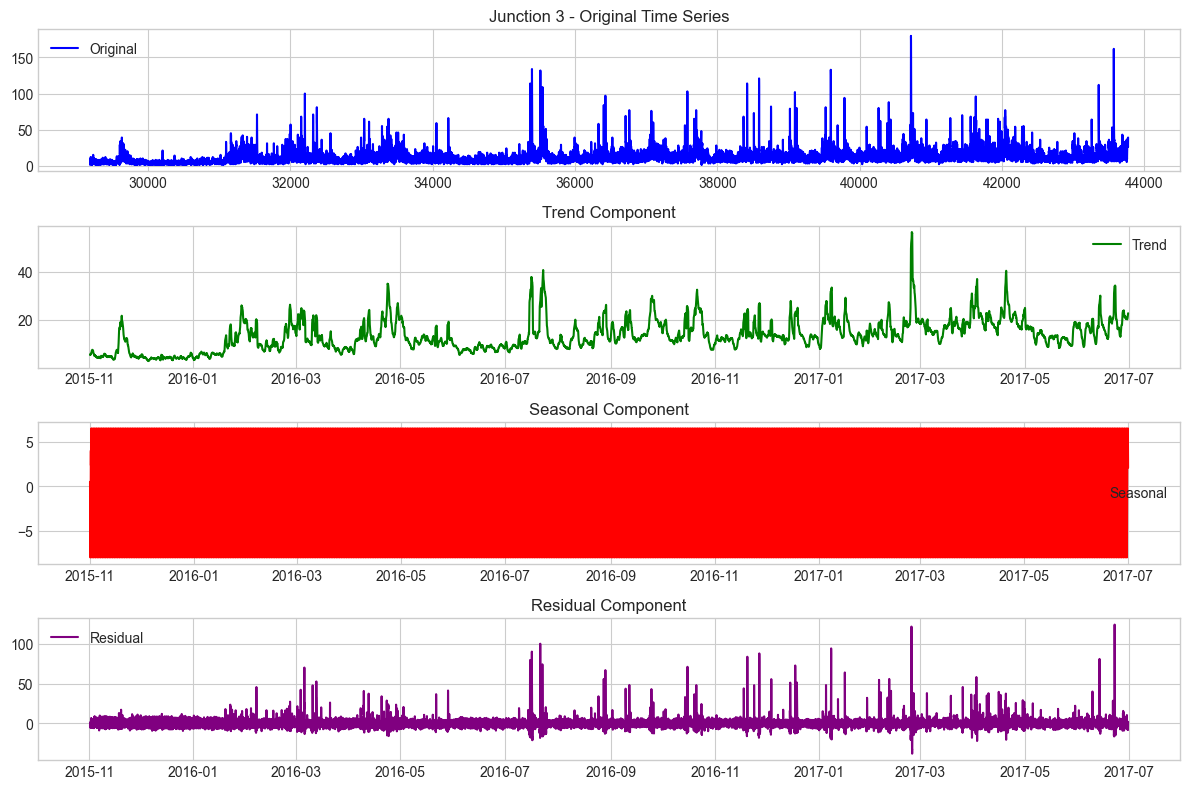

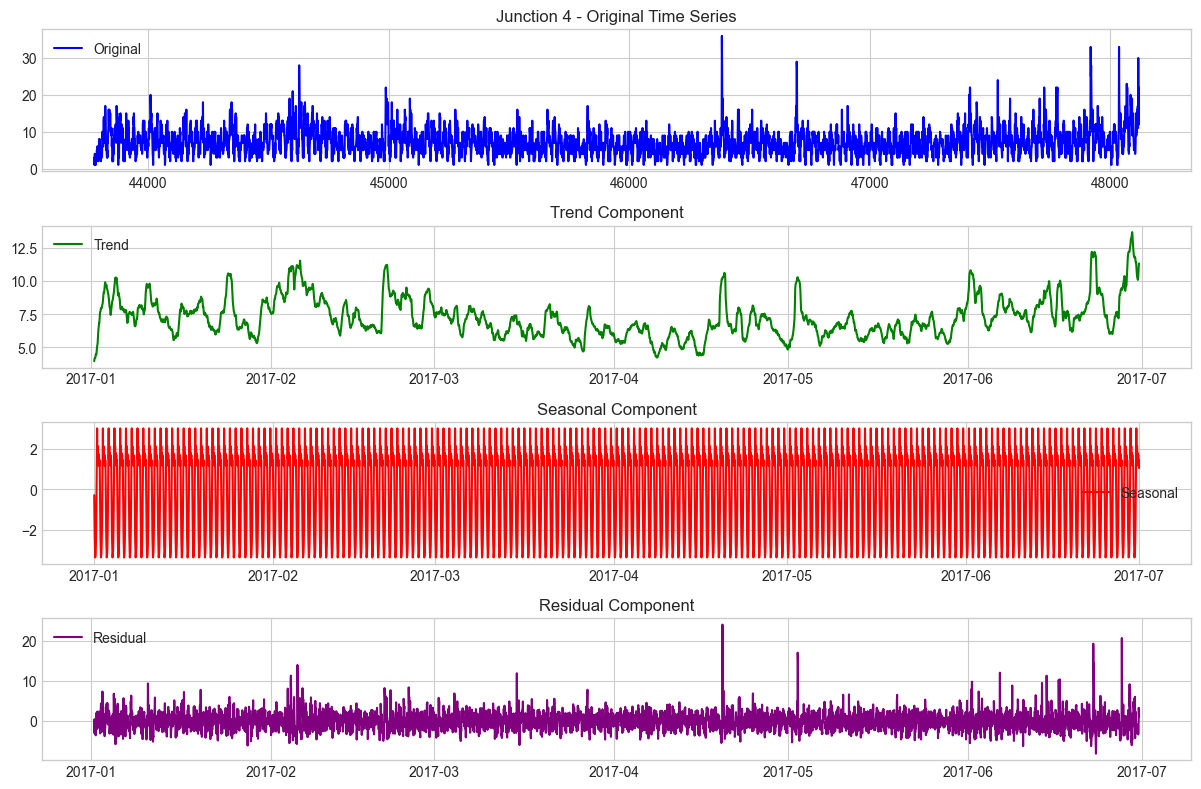

In [59]:
plot_seasonal_decomposition(junction_1, 'Junction 1')
plot_seasonal_decomposition(junction_2, 'Junction 2')
plot_seasonal_decomposition(junction_3, 'Junction 3')
plot_seasonal_decomposition(junction_4, 'Junction 4')

In [63]:
def plot_seasonal_component(dataframe, junction_name):
   
    decomposition = seasonal_decompose(dataframe['Vehicles'], model='additive', period=24*7)  # Assuming a daily seasonality
    
    seasonal_component_from_april_2017 = decomposition.seasonal['2017-04-01':]
    
    plt.figure(figsize=(12, 4))
    plt.plot(seasonal_component_from_april_2017, label='Seasonal Component', color='red')
    plt.title(f'Seasonal Component for {junction_name} starting from April 2017')
    plt.xlabel('Date')
    plt.ylabel('Seasonal Component')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

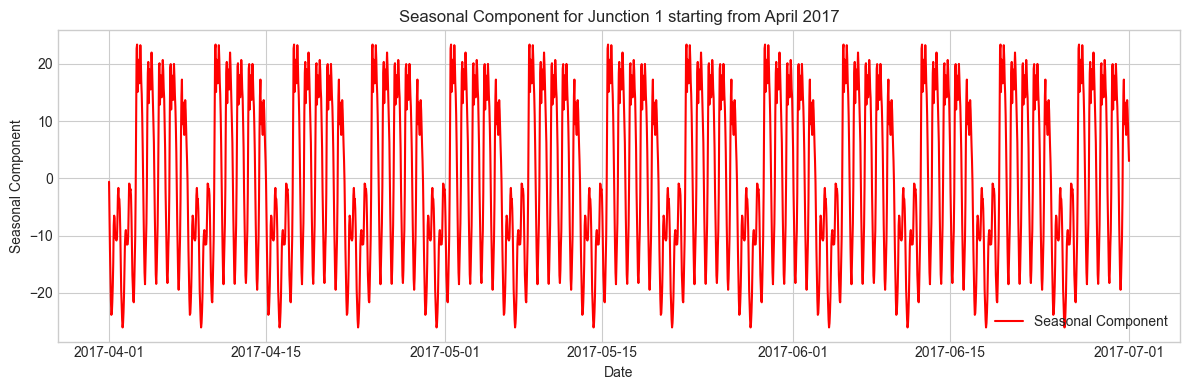

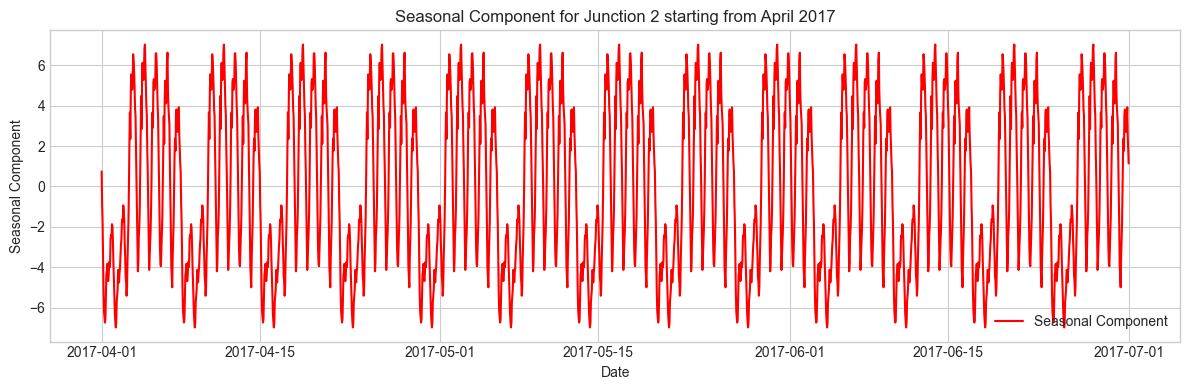

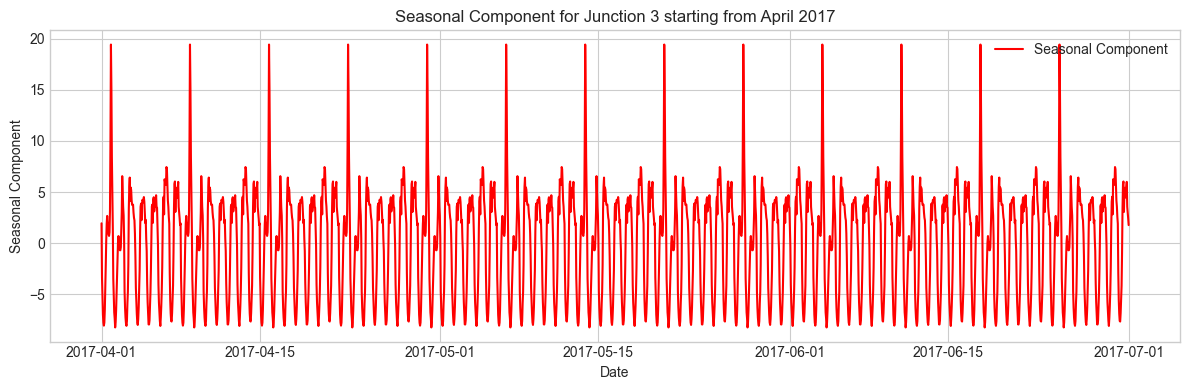

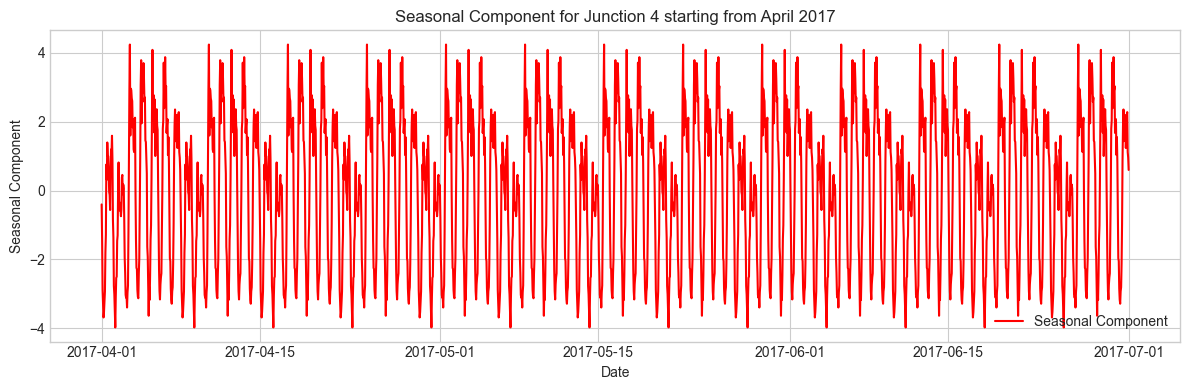

In [64]:
plot_seasonal_component(junction_1, 'Junction 1')
plot_seasonal_component(junction_2, 'Junction 2')
plot_seasonal_component(junction_3, 'Junction 3')
plot_seasonal_component(junction_4, 'Junction 4')